In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.gridspec import GridSpec

In [2]:
df = pd.read_hdf('features_30.h5')

In [3]:
df.head()

,time,waveform,lpc_coeff,amplitude
0,2019-05-27T18:16:37.000000Z,"[3.72132730069, -51.1812948272, -104.97754986,...","[1.0, -2.18162593255, 2.49176485988, -1.993432...","[0.390425590627, 0.366654576689, 0.33067666624..."
1,2019-05-27T17:31:45.000000Z,"[267.286223554, 213.095748702, 156.62064283, 9...","[1.0, -1.91957893956, 1.75126094982, -1.247919...","[0.304056059595, 0.328030528642, 0.44393763535..."
2,2019-05-27T17:17:41.000000Z,"[-150.572442193, -248.678406427, -332.00272918...","[1.0, -2.23007592873, 2.50516095499, -2.071459...","[0.661311999342, 0.584146916956, 0.42782305131..."
3,2019-05-27T19:23:49.000000Z,"[-220.99252159, -347.395354446, -449.371607879...","[1.0, -2.32914670106, 2.68123537773, -2.092240...","[0.382224472907, 0.586558602969, 0.38374742891..."
4,2019-05-27T20:41:11.000000Z,"[157.167620135, 286.219708967, 395.840778773, ...","[1.0, -2.38909167965, 2.78044991558, -2.351892...","[0.430395495412, 0.381969445864, 0.41658439725..."


In [4]:
def check_wf(wf):
    
    if len(wf) != 259:
        return 0
    else:
        return 1    

In [5]:
df['accept_signal'] = df['waveform'].apply(check_wf)

In [6]:
df = df[df['accept_signal']>0]

In [7]:
def scale(vec):
    
    vec-=np.mean(vec)
    vec/=np.std(vec)
    return vec
    

In [8]:
df.waveform = df['waveform'].apply(scale)
df.lpc_coeff = df['lpc_coeff'].apply(scale)
df.amplitude = df['amplitude'].apply(scale)

In [9]:
df.head()

,time,waveform,lpc_coeff,amplitude,accept_signal
0,2019-05-27T18:16:37.000000Z,"[0.0158810999017, -0.0367588506569, -0.0883380...","[0.532978581546, -1.2006501701, 1.34582286513,...","[-0.80383077214, -0.83517702322, -0.8826202083...",1
1,2019-05-27T17:31:45.000000Z,"[0.217929382801, 0.177055765433, 0.13445894607...","[0.546929495243, -1.05886855439, 0.96013064272...","[-1.17846643712, -1.13786962252, -0.9416000278...",1
2,2019-05-27T17:17:41.000000Z,"[-0.149794678508, -0.260617692893, -0.35474298...","[0.483930108041, -1.09174501829, 1.21816816629...","[-0.576909810157, -0.708350230084, -0.97462707...",1
3,2019-05-27T19:23:49.000000Z,"[-0.191800774518, -0.317321693705, -0.41858645...","[0.4570894207, -1.07637940861, 1.23149868469, ...","[-1.0065168605, -0.673603467102, -1.0040355694...",1
4,2019-05-27T20:41:11.000000Z,"[0.102960507618, 0.205200011241, 0.29204559324...","[0.495109947081, -1.20351900811, 1.38747995821...","[-0.714479105475, -0.775221954741, -0.73180295...",1


In [10]:
df.time = df.time.astype(str)

In [11]:
def exclude_days(date):
    
    eruption_days = ['2019-08-28', '2019-08-29', '2019-07-03']
    for d in eruption_days:
        if d in date:
            return 0
    return 1
    
    """
    test_days = ['2019-06-09', '2019-06-10', '2019-06-11', '2019-06-24', '2019-06-25', '2019-06-26']
    for d in test_days:
        if d in date:
            return 1
        else:
            0
    """

In [12]:
df['accept_days'] = df['time'].apply(exclude_days)

In [13]:
df = df[df['accept_days'] > 0]

In [14]:
df.time = pd.to_datetime(df['time'])

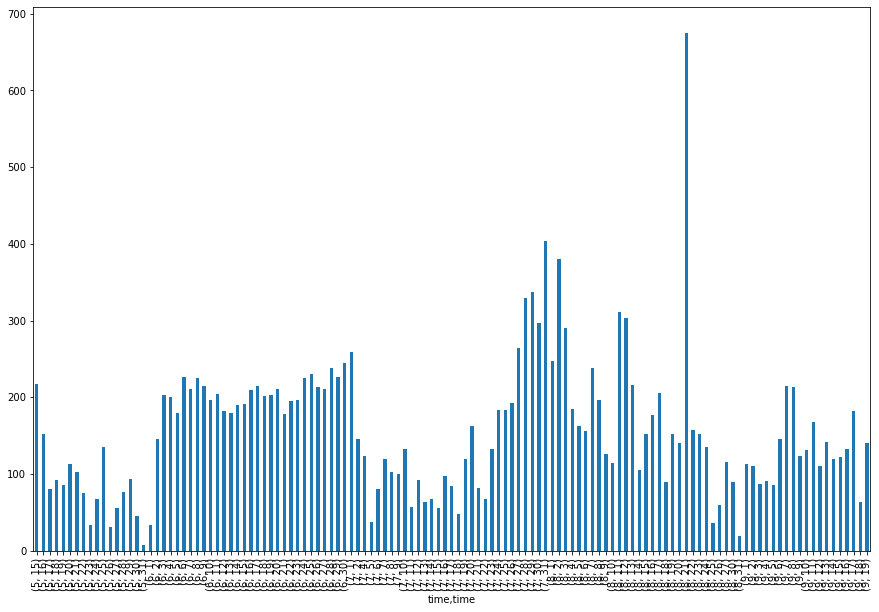

In [15]:
plt.figure(figsize=(15,10))
df['time'].groupby([df["time"].dt.month, df["time"].dt.day]).count().plot(kind="bar")

In [16]:
def final_input(wf, lpc, amp):
    
    #return list(np.concatenate((wf, lpc, amp), axis=None))
    return list(np.concatenate((wf), axis=None))
    #return list(np.concatenate((wf, amp), axis=None))

In [17]:
features = df.apply(lambda x: final_input(x['waveform'], x['lpc_coeff'], x['amplitude']), axis=1)#.to_numpy()#.values

In [18]:
d = pd.DataFrame(features.tolist())

In [19]:
t = d.to_numpy()

In [20]:
t.shape

(19748, 259)

In [147]:
size = 20
from minisom import MiniSom    
som = MiniSom(size, size, t.shape[1], sigma=0.3, learning_rate=.5, random_seed = 1) # initialization of 6x6 SOM sigma .3, lr .5 init

In [148]:
som.pca_weights_init(t)
som.train_random(t, 10000) # trains the SOM with 100 iterations

dict_keys([(17, 13), (19, 14), (19, 17), (17, 15), (12, 9), (9, 11), (19, 10), (15, 10), (11, 6), (18, 12), (10, 11), (13, 8), (18, 14), (10, 10), (16, 13), (10, 13), (11, 15), (1, 6), (18, 16), (19, 18), (11, 14), (13, 6), (15, 8), (11, 7), (9, 10), (19, 15), (11, 12), (13, 13), (16, 17), (15, 11), (0, 6), (18, 15), (14, 11), (19, 16), (12, 8), (8, 9), (11, 5), (16, 16), (17, 14), (12, 7), (11, 8), (13, 10), (19, 12), (14, 10), (0, 5), (10, 7), (16, 11), (13, 11), (13, 7), (1, 8), (11, 10), (13, 14), (16, 15), (18, 18), (11, 16), (19, 11), (14, 9), (19, 19), (11, 11), (17, 17), (12, 10), (18, 11), (9, 7), (15, 12), (3, 9), (11, 13), (12, 14), (18, 17), (16, 14), (10, 12), (12, 12), (12, 13), (2, 6), (1, 9), (17, 16), (13, 12), (14, 12), (8, 8), (5, 8), (13, 9), (4, 9), (1, 7), (3, 8), (4, 7), (10, 6), (17, 12), (0, 10), (11, 9), (10, 8), (19, 13), (15, 9), (0, 7), (10, 9), (0, 9), (2, 9), (12, 11), (12, 6), (16, 12), (14, 13), (2, 10), (8, 7), (2, 8), (3, 10), (2, 7), (8, 10), (9, 8),

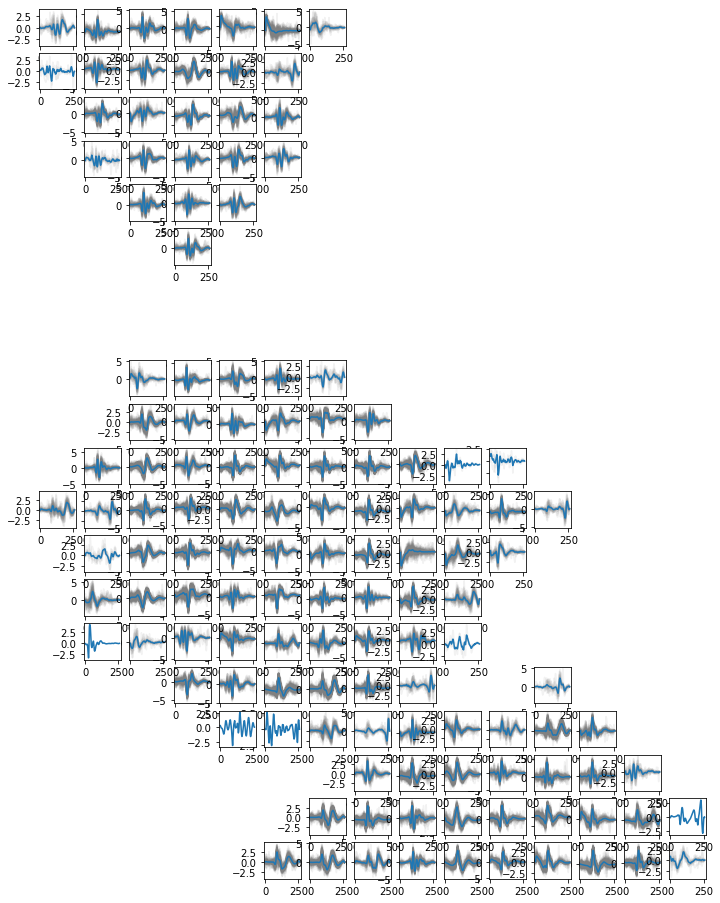

In [149]:
win_map = som.win_map(t)

print( win_map.keys() )

plt.figure(figsize=(16, 16))
the_grid = GridSpec(size, size)
for position in win_map.keys():
    
    #print( 6 - position[1] )
    font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 16,
        }
    plt.subplot(the_grid[position[0], position[1]])
    #plt.plot(np.min(win_map[position], axis=0), color='gray', alpha=.5)
    for vec in win_map[position]:
        plt.plot(vec, color='gray', alpha=.1)
    plt.plot(np.mean(win_map[position], axis=0))
    #plt.text(300, 5000, str(len(win_map[position])), fontdict=font)
    #plt.plot(np.max(win_map[position], axis=0), color='gray', alpha=.5)
    
plt.show()

In [150]:
from matplotlib import cm

In [151]:
cmap = cm.get_cmap('bone_r') #gray_r')

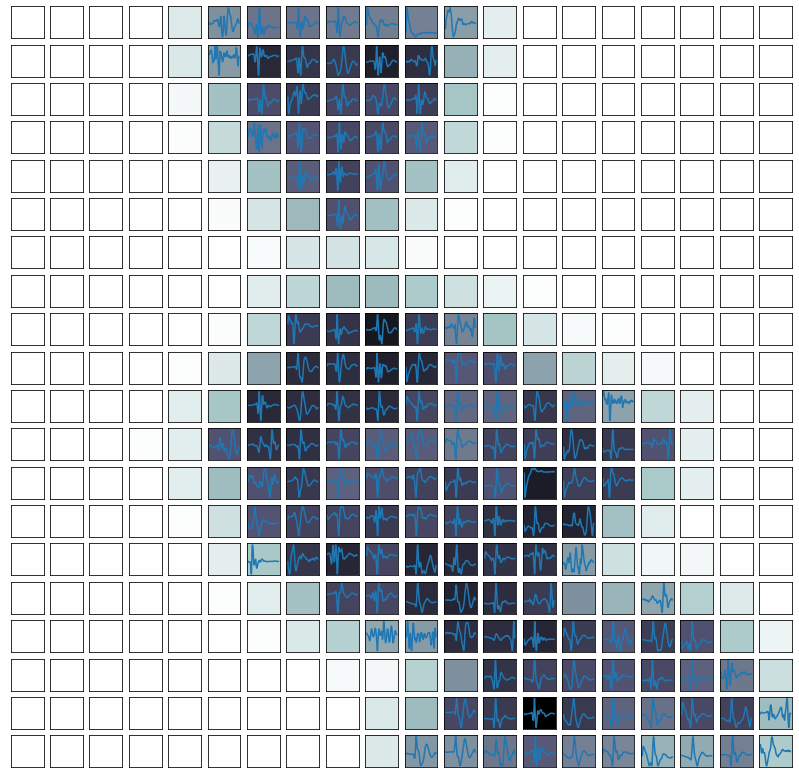

In [152]:
plt.figure(figsize=(14, 14))
#plt.pcolor(som.distance_map().T, cmap='gray_r', alpha=1)
the_grid = GridSpec(size, size)

dmap = som.distance_map() 
#for position in win_map.keys():
for i in range(size):
    for j in range(size):
        
        ax = plt.subplot(the_grid[i, j])
        c = cmap(dmap[i, j])
        ax.set_facecolor((c[0], c[1], c[2]))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        if (i, j) in win_map.keys():
            plt.plot(np.mean(win_map[i, j], axis=0))
        """
        ax = plt.subplot(the_grid[position[0], position[1]])
        #ax.set_facecolor('xkcd:salmon')
        c = cmap(dmap[position[0], position[1]])
        ax.set_facecolor((c[0], c[1], c[2]))
        plt.plot(np.mean(win_map[position], axis=0))
        """
#plt.pcolor(som.distance_map(), cmap='gray_r', alpha=.2)
plt.show()

In [153]:
dmap

array([[ 0.00239284,  0.00408483,  0.00408483,  0.00458073,  0.09645837,
         0.43163373,  0.52087659,  0.52096923,  0.49895545,  0.49050552,
         0.47896094,  0.38346877,  0.07064043,  0.00410291,  0.00408483,
         0.00408483,  0.00408483,  0.00408483,  0.00408483,  0.00239284],
       [ 0.00408483,  0.00676797,  0.00676797,  0.00711649,  0.10487875,
         0.39702806,  0.81974964,  0.75794823,  0.74517441,  0.84934073,
         0.78919892,  0.32759124,  0.07697695,  0.0067771 ,  0.00676797,
         0.00676797,  0.00676797,  0.00676797,  0.00676797,  0.00408483],
       [ 0.00408483,  0.00676797,  0.00676797,  0.00676752,  0.03388713,
         0.26654297,  0.6590135 ,  0.74042235,  0.68412252,  0.68157622,
         0.72225787,  0.25514349,  0.01166411,  0.00676794,  0.00676797,
         0.00676797,  0.00676797,  0.00676797,  0.00676797,  0.00408483],
       [ 0.00408483,  0.00676797,  0.00676797,  0.00676798,  0.01272306,
         0.16758511,  0.52510376,  0.62783254,  

In [154]:
def density_map():
    
    um = np.zeros((size, size))
    for i in range(size):
        for j in range(size):
            um[i,j] = len(win_map[i,j])
    return um/um.max()
density = density_map()

In [155]:
density

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.0243309 ,  0.10340633,  0.15815085,  0.13138686,  0.0863747 ,
         0.16666667,  0.02919708,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.00486618,  0.07420925,  0.10218978,  0.29318735,  0.1459854 ,
         0.03406326,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.14355231,  0.05961071,  0.15450122,  0.14720195,
         0.08029197,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.013382  ,  0.11557178,  

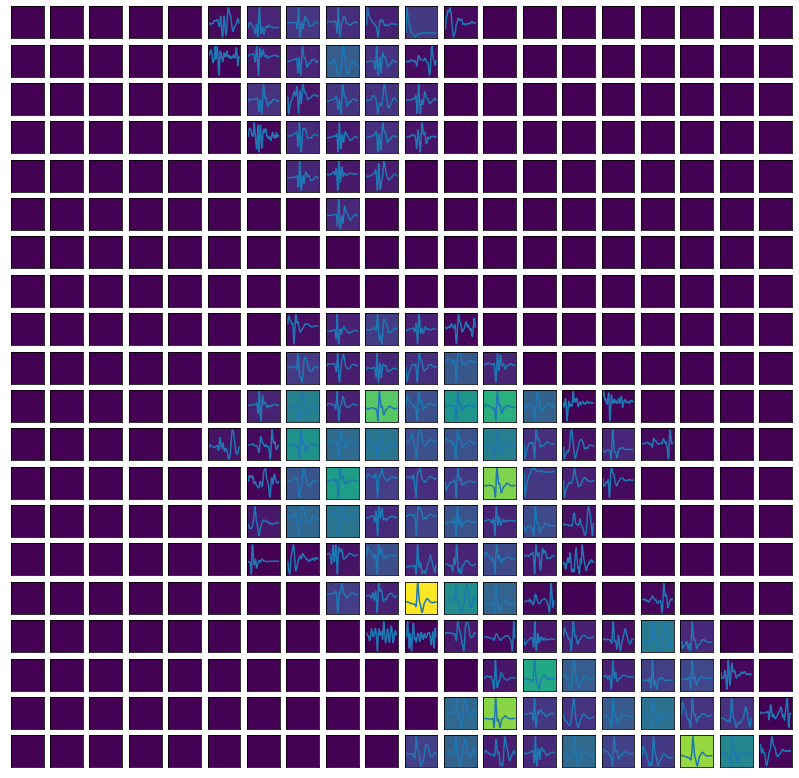

In [156]:
cmap = cm.get_cmap('viridis') #gray_r')
plt.figure(figsize=(14, 14))
#plt.pcolor(som.distance_map().T, cmap='gray_r', alpha=1)
the_grid = GridSpec(size, size)

#for position in win_map.keys():
for i in range(size):
    for j in range(size):
        
        ax = plt.subplot(the_grid[i, j])
        c = cmap(density[i, j])
        ax.set_facecolor((c[0], c[1], c[2]))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        if (i, j) in win_map.keys():
            plt.plot(np.mean(win_map[i, j], axis=0))
        """
        ax = plt.subplot(the_grid[position[0], position[1]])
        #ax.set_facecolor('xkcd:salmon')
        c = cmap(dmap[position[0], position[1]])
        ax.set_facecolor((c[0], c[1], c[2]))
        plt.plot(np.mean(win_map[position], axis=0))
        """
#plt.pcolor(som.distance_map(), cmap='gray_r', alpha=.2)
plt.show()

In [157]:
t2 = df.iloc[0]

In [158]:
def to_cluster(waveform):
    return som.winner(waveform)

def to_index(cluster):
    index = size * cluster[0] + cluster[1]
    return index

In [159]:
som.winner(t2['waveform'])

(17, 13)

In [160]:
df['cluster'] = df['waveform'].apply(to_cluster)
df['cluster_index'] = df['cluster'].apply(to_index)

In [161]:
df.head()

,time,waveform,lpc_coeff,amplitude,accept_signal,accept_days,som,cluster,cluster_index,t1,t2
0,2019-05-27 18:16:37+00:00,"[0.0158810999017, -0.0367588506569, -0.0883380...","[0.532978581546, -1.2006501701, 1.34582286513,...","[-0.80383077214, -0.83517702322, -0.8826202083...",1,1,13,"(17, 13)",353,1558980997000000000,309
1,2019-05-27 17:31:45+00:00,"[0.217929382801, 0.177055765433, 0.13445894607...","[0.546929495243, -1.05886855439, 0.96013064272...","[-1.17846643712, -1.13786962252, -0.9416000278...",1,1,156,"(19, 14)",394,1558978305000000000,409
2,2019-05-27 17:17:41+00:00,"[-0.149794678508, -0.260617692893, -0.35474298...","[0.483930108041, -1.09174501829, 1.21816816629...","[-0.576909810157, -0.708350230084, -0.97462707...",1,1,154,"(17, 13)",353,1558977461000000000,335
3,2019-05-27 19:23:49+00:00,"[-0.191800774518, -0.317321693705, -0.41858645...","[0.4570894207, -1.07637940861, 1.23149868469, ...","[-1.0065168605, -0.673603467102, -1.0040355694...",1,1,158,"(17, 13)",353,1558985029000000000,382
4,2019-05-27 20:41:11+00:00,"[0.102960507618, 0.205200011241, 0.29204559324...","[0.495109947081, -1.20351900811, 1.38747995821...","[-0.714479105475, -0.775221954741, -0.73180295...",1,1,69,"(19, 17)",397,1558989671000000000,383


In [162]:
df['t1'] = df.time.astype(np.int64)
df['t2'] = df.cluster_index.astype(np.int64)


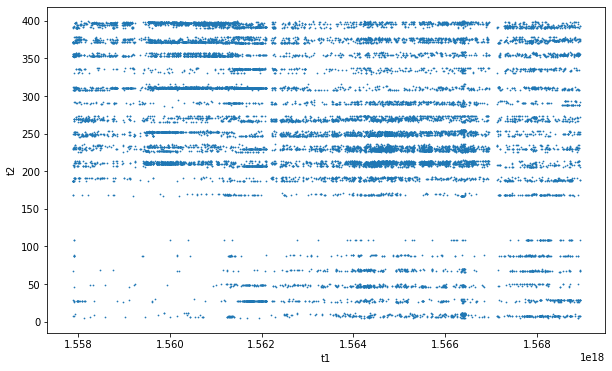

In [163]:
from datetime import datetime
fig, ax = plt.subplots(figsize=(10,6))
df.plot(x='t1', y='t2', kind='scatter', ax=ax, style="o", s=0.5)
#ax.set_xticklabels([datetime.fromtimestamp(ts / 1e9).strftime('%H:%M:%S') for ts in ax.get_xticks()])

/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/pandas/core/series.py:942: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


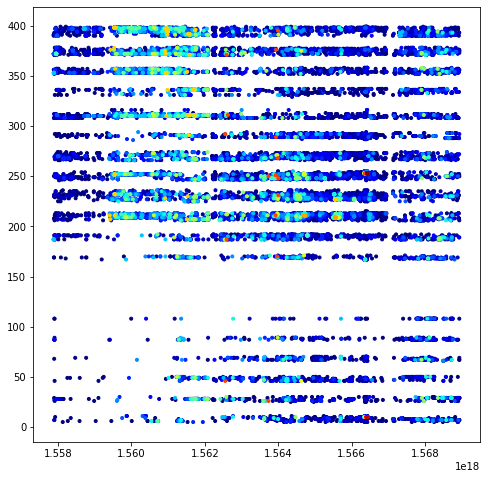

In [168]:
#histogram definition
bins = [1000, 1000] # number of bins

x, y = df['t1'], df['cluster_index']
# histogram the data
hh, locx, locy = np.histogram2d(x, y, bins=bins)

# Sort the points by density, so that the densest points are plotted last
z = np.array([hh[np.argmax(a<=locx[1:]),np.argmax(b<=locy[1:])] for a,b in zip(x,y)])
idx = z.argsort()
x2, y2, z2 = x[idx], y[idx], z[idx]

plt.figure(1,figsize=(8,8)).clf()
s = plt.scatter(x2, y2, c=z2, cmap='jet', marker='.')  
bin

In [174]:
from datetime import date

d0 = date(2019, 5, 15)
d1 = date(2019, 9, 15)
delta = d1 - d0
days = delta.days

In [179]:
from scipy.stats import kde
 
# Evaluate a gaussian kde on a regular grid of nbins x nbins over data extents
nbins=300
k = kde.gaussian_kde([x,y])

bins_y = size*size
bins_x = days

xi, yi = np.mgrid[x.min():x.max():bins_x*1j, y.min():y.max():bins_y*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))

#plt.hist2d(x, y, (bins_x, bins_y), cmap=plt.cm.jet)

In [184]:
d0 = date(2019, 5, 15)
d1 = date(2019, 7, 3)
delta = d1 - d0
er_1 = delta.days

d0 = date(2019, 5, 15)
d1 = date(2019, 8, 28)
delta = d1 - d0
er_2 = delta.days

In [201]:
h = [{'time':'2019-07-04T00:00:00.000000Z'},
     {'time':'2019-08-28T00:00:00.000000Z'} ]
h = pd.DataFrame(h)
h.time = h.time.astype(str)
h.time = pd.to_datetime(h['time'])
h['t1'] = h.time.astype(np.int64)

In [202]:
err1 = h.iloc[0]['t1']
err2 = h.iloc[1]['t1']

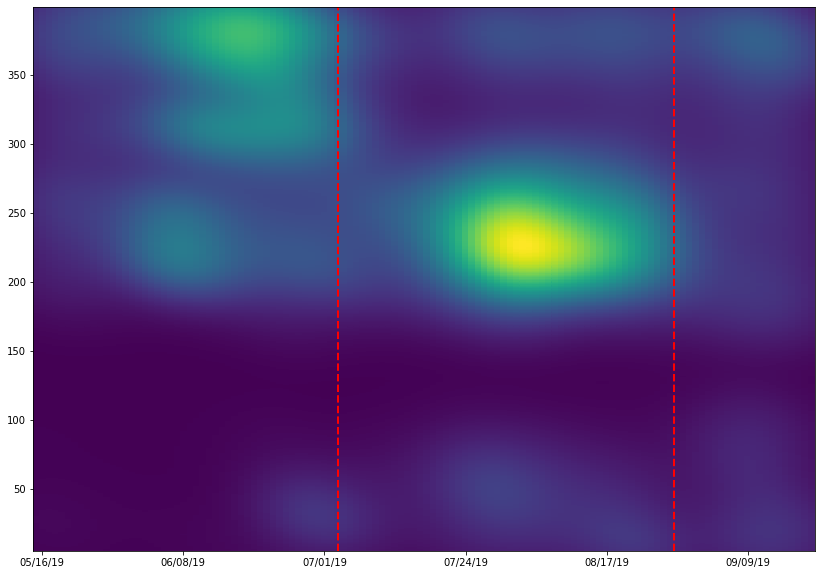

In [203]:
# Make the plot
fig, ax = plt.subplots(figsize=(14,10))
plt.pcolormesh(xi, yi, zi.reshape(xi.shape))
ax.set_xticklabels([datetime.fromtimestamp(ts / 1e9).strftime('%D') for ts in ax.get_xticks()])
ax.axvline(x=err1, color='r', linestyle='dashed', linewidth=2)
ax.axvline(x=err2, color='r', linestyle='dashed', linewidth=2)

plt.show()

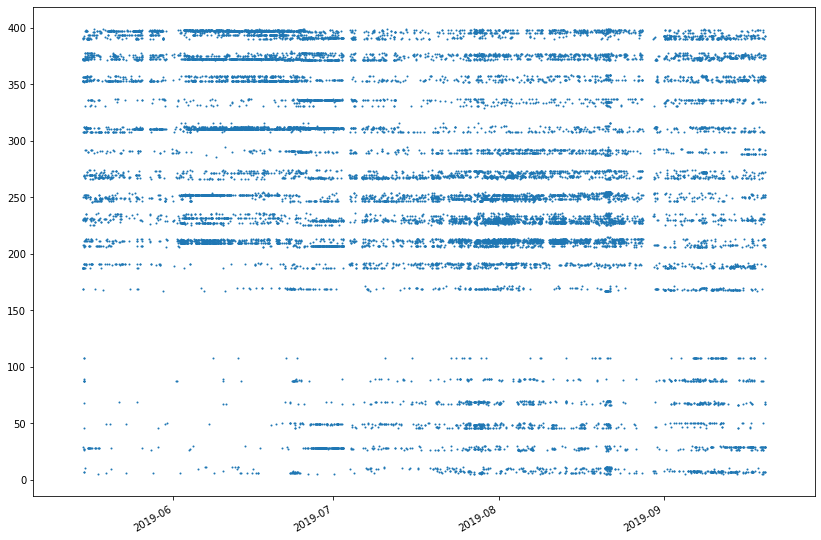

In [164]:
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(14,10))
plt.scatter(df['time'], df['cluster_index'], s =1)
degrees = 70
#plt.xticks(rotation=degrees)
# rotate and align the tick labels so they look better
fig.autofmt_xdate()

# use a more precise date string for the x axis locations in the
# toolbar
ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.xaxis.set_major_locator(mdates.MonthLocator())